<a href="https://colab.research.google.com/github/taaha3244/RAG/blob/main/Suzuki_RAG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain
!pip install -q torch
!pip install -q transformers
!pip install -q sentence-transformers
!pip install -q datasets
!pip install -q faiss-cpu
!pip install jq

#Importing Dependencies

In [30]:
from langchain.document_loaders import HuggingFaceDatasetLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import AutoTokenizer, pipeline
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA
import pandas as pd
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.chat_models import ChatOpenAI

In [3]:
!unzip '/content/archive (1).zip'

Archive:  /content/archive (1).zip
  inflating: Pak Suzuki Car Reviews.csv  


#Data Pre Processing

In [4]:
df=pd.read_csv('/content/Pak Suzuki Car Reviews.csv')

In [5]:
df.head()

,Unnamed: 0,Model,Overall_rating,Date,Review,Style,Comfort,Fuel_Economy,Performance,Value_for_Money
0,0,2023 Suzuki Bolan,1,"Nov 30, 2023",\nis gadi k baray me 3 lafaz kahunga 1 bakwaaa...,1,1,1,1,1
1,1,2022 Suzuki Swift GLX CVT,4,"Nov 29, 2023","\nA good looking car with best fuel ? economy,...",5,4,5,4,5
2,2,2022 Suzuki Cultus Auto Gear Shift,5,"Nov 26, 2023",\nfor me i would must buy because its will sav...,5,5,5,5,5
3,3,2007 Suzuki Liana RXi (CNG),5,"Nov 12, 2023",\nI have used it for more than 5 years. litera...,5,5,5,5,5
4,4,2022 Suzuki Alto VX,4,"Nov 09, 2023",\nExterior: 10/10 on design but the quality us...,5,5,5,4,5


In [6]:
# 1. Removing the 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace=True)




In [7]:
# 2. Converting 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')



In [8]:
# 3. Cleaning the 'Review' column by removing newline characters and trimming spaces
df['Review'] = df['Review'].str.replace('\n', ' ').str.strip()



In [9]:
# Checking for missing values
missing_values = df.isnull().sum()

missing_values

Model              0
Overall_rating     0
Date               0
Review             0
Style              0
Comfort            0
Fuel_Economy       0
Performance        0
Value_for_Money    0
dtype: int64

In [10]:
# Extracting year from the 'Date' column and creating a new 'Year' column
df['Year'] = df['Date'].dt.year

# Displaying the first few rows to confirm the addition of the 'Year' column
df.head()


,Model,Overall_rating,Date,Review,Style,Comfort,Fuel_Economy,Performance,Value_for_Money,Year
0,2023 Suzuki Bolan,1,2023-11-30,is gadi k baray me 3 lafaz kahunga 1 bakwaaas ...,1,1,1,1,1,2023
1,2022 Suzuki Swift GLX CVT,4,2023-11-29,"A good looking car with best fuel ? economy,Dr...",5,4,5,4,5,2023
2,2022 Suzuki Cultus Auto Gear Shift,5,2023-11-26,for me i would must buy because its will save ...,5,5,5,5,5,2023
3,2007 Suzuki Liana RXi (CNG),5,2023-11-12,I have used it for more than 5 years. literall...,5,5,5,5,5,2023
4,2022 Suzuki Alto VX,4,2023-11-09,Exterior: 10/10 on design but the quality used...,5,5,5,4,5,2023


#Save CSV

In [13]:
df.to_csv('suzuki')

#Loading Data to LangChain Data Loader

In [14]:
from langchain_community.document_loaders.csv_loader import CSVLoader

file_path='/content/suzuki'
loader = CSVLoader(file_path)

data = loader.load()


In [ ]:
data

#Text Embedding

Embeddings capture the semnatic meaning of the text which allows you to quickly and efficiently find other pieces of text which are similar.

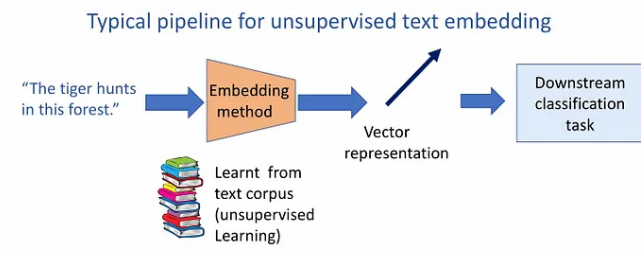


The Embeddings class of LangChain is designed for interfacing with text embedding models. You can use any of them, but I have used here “HuggingFaceEmbeddings”.

In [18]:
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()
#testing the embeddings
text = "This is a test document."
query_result = embeddings.embed_query(text)
query_result[:3]

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

[-0.04895172640681267, -0.039861924946308136, -0.021562771871685982]

In [20]:
db = FAISS.from_documents(data, embeddings)

#Vector Stores
There is a need of databases so that we can store those embeddings and efficiently search them. Therefore, for storage and searching purpose, we need vector stores. You can retrieve the embedding vectors which will be “most similar”. Basically, it does a vector search for you. There are many vector stores integrated with LangChain, but I have used here “FAISS” vector store.

In [36]:
question = "how is alto 2022?"
searchDocs = db.similarity_search(question)
print(searchDocs[0].page_content)

: 282
Model: 2019 Suzuki Alto
Overall_rating: 4
Date: 2020-09-14
Review: Very  nice car, for the first time Alto has exceeded expectation.Reasonable AC, and best fuel economy, very good leg room but seats are not comfortable, drive and response is eager, brakes are better, good option for general commute within the radius of 20-30 kms per day.
Style: 3
Comfort: 3
Fuel_Economy: 5
Performance: 4
Value_for_Money: 5
Year: 2020


In [37]:
docs_and_scores = db.similarity_search_with_score(question)

In [38]:
docs_and_scores[0]

(Document(page_content=': 282\nModel: 2019 Suzuki Alto\nOverall_rating: 4\nDate: 2020-09-14\nReview: Very  nice car, for the first time Alto has exceeded expectation.Reasonable AC, and best fuel economy, very good leg room but seats are not comfortable, drive and response is eager, brakes are better, good option for general commute within the radius of 20-30 kms per day.\nStyle: 3\nComfort: 3\nFuel_Economy: 5\nPerformance: 4\nValue_for_Money: 5\nYear: 2020', metadata={'source': '/content/suzuki', 'row': 282}),
 0.66332984)

#Preparing the LLM Model
You can choose any model from hugging face, and start with a tokenizer to preprocess text and a question-answering model to provide answers based on input text and questions.

In [24]:
# Create a tokenizer object by loading the pretrained  tokenizer.
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# Create a question-answering model object by loading the pretrained  model.
model = AutoModelForQuestionAnswering.from_pretrained("google/flan-t5-base")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Some weights of T5ForQuestionAnswering were not initialized from the model checkpoint at google/flan-t5-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Specify the model name you want to use
model_name = "google/flan-t5-base"

# Load the tokenizer associated with the specified model
tokenizer = AutoTokenizer.from_pretrained(model_name, padding=True, truncation=True, max_length=512)

# Define a question-answering pipeline using the model and tokenizer
question_answerer = pipeline(
    "question-answering",
    model=model_name,
    tokenizer=tokenizer,
    return_tensors='pt'
)

# Create an instance of the HuggingFacePipeline, which wraps the question-answering pipeline
# with additional model-specific arguments (temperature and max_length)
llm = HuggingFacePipeline(
    pipeline=question_answerer,
    model_kwargs={"temperature": 0.8, "max_length": 512}
)

Some weights of T5ForQuestionAnswering were not initialized from the model checkpoint at google/flan-t5-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Retrievers
Once the data is in database, the LLM model is prepared, and the pipeline is created, we need to retrieve the data. A retriever is an interface that returns documents from the query.

In [40]:
# Create a retriever object from the 'db' using the 'as_retriever' method.
# This retriever is likely used for retrieving data or documents from the database.
retriever = db.as_retriever()

In [41]:
docs = retriever.get_relevant_documents("Is suzuki alto 2020 good car?")
print(docs[0].page_content)

: 282
Model: 2019 Suzuki Alto
Overall_rating: 4
Date: 2020-09-14
Review: Very  nice car, for the first time Alto has exceeded expectation.Reasonable AC, and best fuel economy, very good leg room but seats are not comfortable, drive and response is eager, brakes are better, good option for general commute within the radius of 20-30 kms per day.
Style: 3
Comfort: 3
Fuel_Economy: 5
Performance: 4
Value_for_Money: 5
Year: 2020


#Retrieval QA Chain

Now, we’re going to use a RetrievalQA chain to find the answer to a question. To do this, we prepared our LLM model with “temperature = 0.7" and “max_length = 512”. You can set your temperature whatever you desire.



In [28]:
# Create a retriever object from the 'db' with a search configuration where it retrieves up to 4 relevant splits/documents.
retriever = db.as_retriever(search_kwargs={"k": 4})

# Create a question-answering instance (qa) using the RetrievalQA class.
# It's configured with a language model (llm), a chain type "refine," the retriever we created, and an option to not return source documents.
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="refine", retriever=retriever, return_source_documents=False)

In [42]:
question = "Who is Thomas Jefferson?"
result = qa.run({"query": question})
print(result["result"])

ValueError: Context information is below. 
------------
: 99
Model: 2022 Suzuki Swift GL CVT
Overall_rating: 3
Date: 2022-07-14
Review: i m use to keep that in my garage since 2011. i just disposed off my 2021 swift and bought GL CVT.But its fuel ?? consumptions is little good then to Ex model but as good as ut shoukd be. its nit under power ..its upgraded ergonomatic , aerodynamics  looks cross air shaped style like blondy smooth husky style . kerab weight reduced ..its little complicated to estimate as it is 1200CC  then weight reduced much  but over all its very good hatch pack  NISSAN JUKE COPY.
Style: 5
Comfort: 4
Fuel_Economy: 2
Performance: 4
Value_for_Money: 4
Year: 2022
------------
Given the context information and not prior knowledge, answer the question: Who is Thomas Jefferson?
 argument needs to be of type (SquadExample, dict)